# PART I: KNN Model for `DISCHARGE` feature

- Gabriel Wendell Celestino Rocha
- Alberto Bezerra de Palhares Júnior
- Joab Morais Varela
- Rafael Chaves Souto Araújo

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.collections import PolyCollection, LineCollection

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic: single plot

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20

def sm_plot(grid = True, dark_background = False, use_tex = False, font_family = 'monospace', font_size = 15, 
            minorticks = True, major_ticks = True, minor_ticks = True, grid_linestyle = ':', grid_color = '0.50', 
            tick_length_minor = 5, tick_width_minor = 1, tick_length_major = 8, tick_width_major = 1, labelsize = 15):
    """
    Function to improve the aesthetics of Matplotlib graphs.
    """
    if dark_background:
        plt.style.use('dark_background')
    
    if grid:
        plt.grid(True, linestyle = grid_linestyle, color = grid_color, zorder = 0)
    else:
        plt.grid(False)
    
    plt.rcParams['text.usetex'] = use_tex
    plt.rcParams['font.family'] = font_family
    plt.rcParams['font.size'] = font_size
    
    if minorticks:
        plt.minorticks_on()
    else:
        plt.minorticks_off()
    
    if minor_ticks:
        plt.tick_params(axis = 'both', which = 'minor', direction = "in", 
                        top = True, right = True, length = tick_length_minor, 
                        width = tick_width_minor, labelsize = labelsize)
    
    if major_ticks:
        plt.tick_params(axis = 'both', which = 'major', direction = "in", 
                        top = True, right = True, length = tick_length_major, 
                        width = tick_width_major, labelsize = labelsize)

- ### **Aesthetics: plot axes**

In [3]:
def sm_plot_mod(ax, grid = True, dark_background = False, use_tex = False, font = 'monospace', font_size = 15, 
                minor_ticks = True, minor_tick_params = True, major_tick_params = True):
    
    if dark_background:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')

    ax.grid(grid, linestyle = ':', color = '0.50')
    
    plt.rcParams['font.family'] = font
    plt.rcParams['font.size'] = font_size
    
    plt.rcParams['text.usetex'] = use_tex
    
    if minor_ticks:
        ax.minorticks_on()
    else:
        ax.minorticks_off()

    if minor_tick_params:
        ax.tick_params(axis = 'both', which = 'minor', direction = "in", 
                       top = True, right = True, length = 5, width = 1, labelsize = font_size)

    if major_tick_params:
        ax.tick_params(axis = 'both', which = 'major', direction = "in", 
                       top = True, right = True, length = 8, width = 1, labelsize = font_size)

---

## 1. Reading the Data

Reading river station, river-dam station and weather station data:

- **River station:** Kluserbrücke 
- **Weather station:** Wuppertal-Buchenhofen 
- **River-damn station:** Wupper-Talsperre 

- `data_reduced.csv`: Dataframe with all data from 1990 to 2023
- `data_reduced_weekly.csv`: Dataframe with data reduced according to a weekly average
- `data_reduced_monthly.csv`: Dataframe with data reduced according to a monthly average

In [4]:
df = pd.read_csv('../../Reduced_Data/data_reduced.csv', sep = ',')
df_weekly = pd.read_csv('../../Reduced_Data/data_reduced_weekly.csv', sep = ',')
df_monthly = pd.read_csv('../../Reduced_Data/data_reduced_monthly.csv', sep = ',')

df = df.rename(columns = {'  RS': 'RS'})
df = df.rename(columns = {' RSF': 'RSF'})
df.dropna()

df_weekly = df_weekly.rename(columns = {'  RS': 'RS'})
df_weekly = df_weekly.rename(columns = {' RSF': 'RSF'})
df_weekly.dropna()

df_monthly = df_monthly.rename(columns = {'  RS': 'RS'})
df_monthly = df_monthly.rename(columns = {' RSF': 'RSF'})
df_monthly.dropna()


columns_to_remove = ['RS1', 'RS2', 'RS3', 'RS7', 'RS14']
df = df.drop(columns = columns_to_remove)

df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])

# -------------------------------------------------------------------------------------------------

print('River station: Kluserbrücke')
print('Weather station: Wuppertal-Buchenhofen')
print('River-damn station: Wupper-Talsperre')

print('')

print('1) All Data (1990 - 2024):', df.shape)
print('2) Weekly Average:', df_weekly.shape)
print('3) Monthly Average:', df_monthly.shape)

River station: Kluserbrücke
Weather station: Wuppertal-Buchenhofen
River-damn station: Wupper-Talsperre

1) All Data (1990 - 2024): (12062, 7)
2) Weekly Average: (1774, 12)
3) Monthly Average: (408, 12)


---

## 2. ML Model: Classification

Development of a flood classification algorithm using KNN.

**Objetive:** Predict the class of each measurement day (flooding or non-flooding)

- **PART I**
> **I.1.** Data Preprocessing ; \
> **I.2.** Feature Selection ; \
> **I.3.** Data Splitting : 
>> - Training dataset: from $1990$ to $2022$ ; 
>> - Testing dataset: the year $2023$ .

- **PART II**

> **II.1.** Normalization ; \
> **II.2.** Model Training ; \
> **II.3.** Model Evalutation ; \
> **II.4.** *(Optional)* Hyperparameter Tuning ; \
> **II.5.** *(Optional)* Plot Metrics .

In [5]:
# STEP I.1
df = df.dropna(subset = ['WATER-LEVEL'])
df = df.dropna(subset = ['DISCHARGE', 'RS', 'RSF'])
df_knn = df.copy()


df_knn['WATER-LEVEL'] = df['WATER-LEVEL'].round().astype(int)
df_knn['DISCHARGE'] = df['DISCHARGE'].round().astype(int)

display(df_knn)


# STEP I.2.
features = ['WATER-LEVEL', 'DISCHARGE', 'RS', 'RSF']
X = df_knn[features]
y = df_knn['FLOOD']

# STEP I.3.
train_df_knn = df_knn[df['MESS_DATUM'] < '2023-01-01']
test_df_knn = df_knn[df['MESS_DATUM'] >= '2023-01-01']

X_train = train_df_knn[features]
y_train = train_df_knn['FLOOD']
X_test = test_df_knn[features]
y_test = test_df_knn['FLOOD']

y_train = y_train.astype(int)
y_test = y_test.astype(int)



# --------------------------------------------------------------------------



# STEP II.1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP II.2
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

# STEP II.3
y_pred = knn.predict(X_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

,MESS_DATUM,WATER-LEVEL,DISCHARGE,RS,RSF,FLOOD,PIVOT
0,1990-01-01,5,22,0.1,6.0,0,1
1,1990-01-03,5,22,0.0,0.0,0,3
2,1990-01-04,5,22,0.0,6.0,0,4
3,1990-01-06,4,20,0.0,0.0,0,6
4,1990-01-07,4,20,0.0,0.0,0,7
...,...,...,...,...,...,...,...
12057,2023-12-27,77,173,2.8,4.0,0,12414
12058,2023-12-28,70,161,0.3,4.0,0,12415
12059,2023-12-29,67,155,17.6,4.0,0,12416
12060,2023-12-30,60,144,0.1,4.0,0,12417



Confusion Matrix:
 [[364   1]
 [  0   0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       365
           1       0.00      0.00      0.00         0

    accuracy                           1.00       365
   macro avg       0.50      0.50      0.50       365
weighted avg       1.00      1.00      1.00       365

Accuracy Score: 0.9972602739726028


- **Conclusion:** It can be clearly seen that the model is overfitting the data. The reason for the overfit is probably the small number of flooding cases (label `1`) in the dataframe. In other words, for this river station, a classification algorithm is extremely inefficient.

---

## 3. ML Model: Regression

Development of a flood regression algorithm using KNN.

**Objective:** Predict the value of the `DISCHARGE` feature and, based on that, predict whether or not there will be flooding.

- **PART I**
> **I.1.** Data Preprocessing ; \
> **I.2.** Feature Selection ; \
> **I.3.** Data Splitting : 
>> - Training dataset: from $1990$ to $2022$ ; 
>> - Testing dataset: the year of $2023$ .

- **PART II**

> **II.1.** Normalization ; \
> **II.2.** Model Training ; \
> **II.3.** Model Evalutation ; \
> **II.4.** *(Optional)* Hyperparameter Tuning ; \
> **II.5.** *(Optional)* Plot Metrics .

In [6]:
# STEP I.1
df_knr = df.copy()
display(df_knr)

# STEP I.2
X = df_knr[['WATER-LEVEL', 'RS', 'RSF']]  
y = df_knr['DISCHARGE']  

# STEP I.3
train_end_date = pd.to_datetime('2022-12-31')

X_train = X[df_knr['MESS_DATUM'] <= train_end_date]
y_train = y[df_knr['MESS_DATUM'] <= train_end_date]
X_test = X[df_knr['MESS_DATUM'] > train_end_date]
y_test = y[df_knr['MESS_DATUM'] > train_end_date]



# --------------------------------------------------------------------------



# STEP II.1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP II.2
knr = KNeighborsRegressor(n_neighbors = 7)
knr.fit(X_train_scaled, y_train)

# STEP II.3
y_pred = knr.predict(X_test_scaled)

def adjusted_r2_score(y_true, y_pred, n_samples, n_predictors):
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_predictors - 1))
    
    return adjusted_r2



mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
adjusted_r2 = adjusted_r2_score(y_test, y_pred, n_samples = len(y_test), n_predictors = X.shape[1])

print(f'\nMean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')

,MESS_DATUM,WATER-LEVEL,DISCHARGE,RS,RSF,FLOOD,PIVOT
0,1990-01-01,4.548,22.0,0.1,6.0,0,1
1,1990-01-03,4.548,22.0,0.0,0.0,0,3
2,1990-01-04,4.548,22.0,0.0,6.0,0,4
3,1990-01-06,3.799,20.0,0.0,0.0,0,6
4,1990-01-07,3.799,20.0,0.0,0.0,0,7
...,...,...,...,...,...,...,...
12057,2023-12-27,77.293,172.9,2.8,4.0,0,12414
12058,2023-12-28,70.436,161.4,0.3,4.0,0,12415
12059,2023-12-29,66.657,154.9,17.6,4.0,0,12416
12060,2023-12-30,60.286,143.7,0.1,4.0,0,12417



Mean Squared Error: 12.437981865921168
Mean Absolute Error: 2.9348782778864964
Root Mean Squared Error: 3.5267523113937513
R-squared: 0.9909482178521096
Adjusted R-squared: 0.9908729952857837


In [7]:
# STEP II.4

# Define the parameter grid
param_grid = {'n_neighbors': np.arange(1, 50)}

# Initialize GridSearchCV
knr_cv = GridSearchCV(knr, param_grid, cv = 10)

# Fit the model
knr_cv.fit(X_train, y_train)

# Best parameters
print("Best parameters:", knr_cv.best_params_)

# Predict with the best model
best_knr = knr_cv.best_estimator_
y_pred_best = best_knr.predict(X_test)

# Evaluate the best model
mse_opt = mean_squared_error(y_test, y_pred_best)
mae_opt = mean_absolute_error(y_test, y_pred_best)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_opt = r2_score(y_test, y_pred_best)
adjusted_r2_opt = adjusted_r2_score(y_test, y_pred_best, n_samples = len(y_test), n_predictors = X.shape[1])

print(f'\nMean Squared Error: {mse_opt}')
print(f'Mean Absolute Error: {mae_opt}')
print(f'Root Mean Squared Error: {rmse_opt}')
print(f'R-squared: {r2_opt}')
print(f'Adjusted R-squared: {adjusted_r2_opt}')



# --------------------------------------------------------------------------



# STEP II.5
knr_metrics = ['MAE', 'RMSE', '$R^{2}$', 'Ad-$R^{2}$']
knr_metrics_values = [mae, rmse, r2, adjusted_r2]
knr_metrics_values_opt = [mae_opt, rmse_opt, r2_opt, adjusted_r2_opt]

Best parameters: {'n_neighbors': 34}

Mean Squared Error: 13.95979734657061
Mean Absolute Error: 3.0552746172441587
Root Mean Squared Error: 3.736281218882033
R-squared: 0.9898407116385921
Adjusted R-squared: 0.9897562854195222


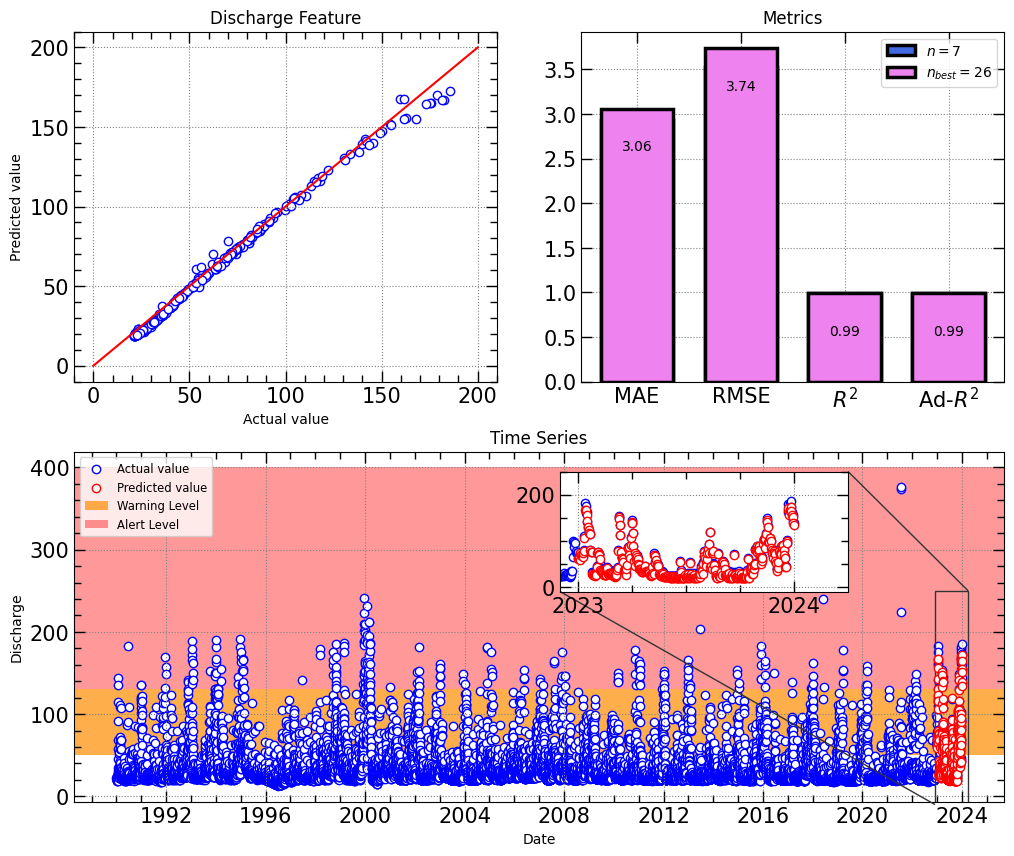

In [8]:
train_df = df[df['MESS_DATUM'] < '2023-01-01']
test_df = df[df['MESS_DATUM'] >= '2023-01-01']

results_df = test_df[['MESS_DATUM']].copy()
results_df['Actual'] = test_df['WATER-LEVEL'].values
results_df['Predicted'] = y_pred

x = np.linspace(0, 200, 200)
y = x

# --------------------------------------------------------------------------



fig = plt.figure(figsize = (12,10))
#fig.subplots_adjust(hspace = 0)
spec = gridspec.GridSpec(ncols = 2, nrows = 2, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, :])


ax0.scatter(y_test, y_pred, color = 'white', edgecolors = 'b', zorder = 1)
ax0.plot(x, y, color = 'red', label = r'$y=x$')


bars = ax1.bar(knr_metrics, knr_metrics_values, color = 'royalblue', edgecolor = 'k', 
               width = 0.7, linewidth = 2.5, zorder = 2, label = r'$n=7$')
bars_opt = ax1.bar(knr_metrics, knr_metrics_values_opt, color = 'violet', edgecolor = 'k', 
               width = 0.7, linewidth = 2.5, zorder = 2, label = r'$n_{best}=26$')

for bar, value in zip(bars_opt, knr_metrics_values_opt):
    ax1.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() - 0.5, 
             f'{value:.2f}', 
             ha = 'center', 
             va = 'bottom')


ax2.scatter(df['MESS_DATUM'], df['DISCHARGE'], label = 'Actual value', 
            color = 'white', edgecolors = 'b', zorder = 1)
ax2.scatter(results_df['MESS_DATUM'], results_df['Predicted'], label = 'Predicted value',
           color = 'white', edgecolors = 'r', zorder = 2)
ax2.axhspan(50, 130, facecolor = 'darkorange', alpha = 0.7, label = 'Warning Level', zorder = 0)
ax2.axhspan(130, 400, facecolor = 'red', alpha = 0.4, label = 'Alert Level', zorder = 0)


ax0.set_xlabel('Actual value')
ax0.set_ylabel('Predicted value')
ax0.set_title('Discharge Feature')

ax1.set_title('Metrics')

ax2.set_xlabel('Date')
ax2.set_ylabel('Discharge')
ax2.set_title('Time Series')


# ZOOM
ax2t = plt.axes([0.53, 0.32, 0.24, 0.12])
ax2t.scatter(df['MESS_DATUM'], df['DISCHARGE'], label = 'Actual value', 
            color = 'white', edgecolors = 'b', zorder = 1)
ax2t.scatter(results_df['MESS_DATUM'], results_df['Predicted'], label = 'Predicted value',
           color = 'white', edgecolors = 'r', zorder = 2)

mark_inset(ax2, ax2t, loc1 = 3, loc2 = 1, fc = 'none', ec = '0.2')

ax2t.set_xlim(pd.to_datetime('2022-12-01'), pd.to_datetime('2024-04-01'))
ax2t.set_ylim(-10, 250)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


ax1.legend(loc = 'best')
ax2.legend(loc = 'best', fontsize = 'small')

sm_plot_mod(ax0)
sm_plot_mod(ax1, minor_ticks = False)
sm_plot_mod(ax2)
sm_plot_mod(ax2t)

plt.savefig('..\Plots\KNN_Model_DISCHARGE.png', dpi = 400)

- **Conclusion:**

---

## Appendix

- #### Mean Absolute Error (MAE)

$$
\text{MAE}=\frac{1}{n}\sum_{i=1}^{n}\left|y_{\text{true},i}-y_{\text{pred.},i}\right|\text{ }.
$$

- #### Root Mean Squared Error (RMSE)

$$
\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(y_{\text{true},i}-y_{\text{pred.},i}\right)^{2}}\text{ }.
$$

- #### $R$-Squared $(R^{2})$

$$
R^{2}=1-\frac{\sum_{i=1}^{n}\left(y_{\text{true},i}-y_{\text{pred.},i}\right)^{2}}{\sum_{i=1}^{n}\left(y_{\text{true},i}-\overline{y}_{\text{pred.},i}\right)^{2}}\text{ }.
$$

- #### Adjusted $R$-Squared $(\tilde{R^{2}})$

$$
\tilde{R^{2}}=1-\frac{\left(1-R^{2}\right)\left(n-1\right)}{n-k-1}\text{ }.
$$

**Legend**:

- $\overline{y}_{\text{true}}$: mean of the true value $y_{\text{true}}$;
- $n$: number of samples;
- $k$: number of predictors.

---